In [3]:
import sys, traceback, os
import argparse
import string
import cv2
import numpy as np
LIBRARY_PATH = '/home/iizuka/workspace/py2/lib'
PLANTCV_PATH = '/home/iizuka/workspace/py2/lib/plantcv'
sys.path.append(LIBRARY_PATH)
sys.path.append(PLANTCV_PATH)
import plantcv as pcv
from database_manipulator import EnvironmentalDatabaseManipulator
from matplotlib import pyplot as plt
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('ggplot')



SHAPES_PROPERTIES = (
    'name',
    'object_area',
     'convex-hull_area',
     'solidity',
     'object_perimeter_length',
     'object_width_(extent_x)',
     'object_height_(extent_y)',
     'longest_axis',
     'center_of_mass-x',
     'center_of_mass-y',
     'hull_vertices',
     'in_bounds',
     'object_bounding_ellipse_center-x',
     'object_bounding_ellipse_center-y',
     'object_bounding_ellipse_major_axis',
     'object_bounding_ellipse_minor_axis',
     'object_bounding_ellipse_angle',
     'object_bounding_ellipse_eccentricity',
)

In [ ]:

def get_shapedata_dict(shape_data):
    if len(shape_data) == len(SHAPES_PROPERTIES):
        shape_dict = {prop:shape_data[i] for i, prop in enumerate(SHAPES_PROPERTIES)}
        return shape_dict
    else:
        print('length of shape data is not compatible')
        
def get_plant_data(img_file, hyper_parameters, options, debug=None, count=0):
    img, path, filename = pcv.readimage(img_file)
    device = 0
    shape_data_dict = {}
    if np.average(img) < 50:
        #pcv.fatal_error("Night Image{}".format(img_file))
        return None
    else:
        pass
    for pos in hyper_parameters['roi']:
        #following variable needs to be given
        #print(1)
        device, b = pcv.rgb2gray_lab(img, 'b', device, debug)
        #print(2)
        device, b_cnt = pcv.binary_threshold(b, hyper_parameters['bin_threshold'], 255, 'light', device, debug)
        #print(3)
        device, masked = pcv.apply_mask(img, b_cnt, 'white', device, debug)
        #print(4)
        device, id_objects,obj_hierarchy = pcv.find_objects(masked, b_cnt, device, debug)
        #print(5)
        params = hyper_parameters['roi'][pos]
        device, roi1, roi_hierarchy= pcv.define_roi(
            masked, 'rectangle', device, None, 'default', 
            debug, True, params['x'], params['y'], params['width'], params['height'])
        #print(6)
        device,roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(
            img, 'partial', roi1, roi_hierarchy, 
            id_objects, obj_hierarchy, device, debug)
        #print(6)
        device, obj, mask = pcv.object_composition(
            img, roi_objects, hierarchy3, device, debug)
        #print(7)
        filename = 'img_{}.jpg'.format(pos)
        try:
            device, shape_header, shape_data, shape_img = pcv.analyze_object(
                img, 'hoge.jpg', obj, b_cnt, device, 
                debug, options['outdir'] + '/' + filename)
            shape_data_dict[pos] = get_shapedata_dict(shape_data)
            shape_data_dict[pos]['contour_area'] = cv2.contourArea(obj)
            #print('area of {} is {}'.format(pos,  shape_data_dict[pos]['contour_area'] ))
        except:
            shape_data_dict[pos] = None
    return shape_data_dict

In [ ]:
hyper_parameters = {
    'bin_threshold':107,
    'roi':{
        'left':{
            'x':200,
            'y':300,
            'width':-800,
            'height':-150
        },
        'right':{
            'x':800,
            'y':300,
            'width':-350,
            'height':-150
        },
        'top':{
            'x':550,
            'y':0,
            'width':-600,
            'height':-600
        }
    }
}
IMG_DATABASE_PATH = '/home/iizuka/ImageDatabase/aerial_image'
img_file = IMG_DATABASE_PATH + '/' +'1511486318.jpg'
out_dir = '/home/iizuka/workspace/py2/generated_imgs/plantcv'
options = {'outdir':out_dir}
#result = get_plant_data(img_file, hyper_parameters, options, debug='plot')

In [ ]:
start_filename = '1511388442.jpg'
end_filename = '1511585654.jpg'
start_index = 1511388442
end_index = 1511585654

image_files = [f for f in os.listdir(IMG_DATABASE_PATH) if os.path.isfile(os.path.join(IMG_DATABASE_PATH, f))]
# plants are not overlayes with each other, which is validated by visual observation 
valid_files = [ filename for filename in image_files if start_index < int(filename.split('.')[0]) < end_index]


In [ ]:
out_dir = '/home/iizuka/workspace/py2/generated_imgs/plantcv'
options = {'outdir':out_dir}
result_dict = {}
night_images = []
failed_images = []
for filename in valid_files:
    print(filename)
    img_file = IMG_DATABASE_PATH + '/' + filename
    result = get_plant_data(img_file, hyper_parameters, options)
    if result is None:
        night_images.append(filename)
    else:
        result_dict[filename.split('.')[0]]  = result

In [ ]:
len(night_images)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
result_dict['1511582036']

In [ ]:
import pickle
obj_file_path = 'obj_files/result_doc.dat'
filehandler = open(obj_file_path, 'w')
data = pickle.dump(result_dict, filehandler)

In [ ]:
import pickle
obj_file_path = 'obj_files/result_doc.dat'
openfilehandler = file(obj_file_path,'r')
data_read = pickle.load(openfilehandler)
data_read

In [ ]:
result_dict

In [1]:
import pandas as pd
import pickle

obj_file_path = 'obj_files/result_doc.dat'
openfilehandler = file(obj_file_path,'r')
data_read = pickle.load(openfilehandler)
data_read

result_dict = data_read
pos_list = ('top', 'left', 'right')
pos_dict = {}
MAX_THREHSOLD = 200000.0
for pos in pos_list:
    print(pos)
    pos_dict[pos] = {}
    contour_area = 'contour_area'
    for time_stamp in result_dict:
        if result_dict[time_stamp] is not None:
            if pos in result_dict[time_stamp]:
                try:
                    value = result_dict[time_stamp][pos][contour_area]
                    if value < MAX_THREHSOLD:
                        pos_dict[pos][pd.to_datetime(int(time_stamp), unit='s')] = value
                except:
                    print('error occurs in {} {}'.format(pos, time_stamp))
        else:
            print('none',time_stamp)
            
df_dict = {pos: pd.Series(pos_dict[pos]) for pos in pos_dict}
df = pd.DataFrame(df_dict)
#df.columns = ['date', 'LAI']
df.head()

top
left
error occurs in left 1511509388
right
error occurs in right 1511509388


,left,right,top
2017-11-22 23:07:35,49612.5,50260.5,63835.0
2017-11-23 00:07:48,49767.0,50917.5,64781.5
2017-11-23 01:08:01,49392.5,51738.5,65375.0
2017-11-23 02:08:13,49579.0,52650.5,66717.5
2017-11-23 03:08:25,49776.0,53315.0,67239.5


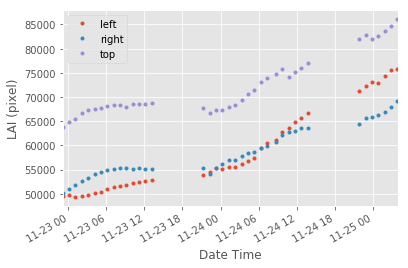

In [4]:
lai_graph = df.plot(style=['.','.','.'])
lai_graph.set_xlabel('Date Time')
lai_graph.set_ylabel('LAI (pixel)')
plt.show()
fig = lai_graph.get_figure()
fig.savefig('plots/lai_graph.png')